Usage of Operations
===================

This notebook serves to show how operations provided by the toolbox can be applied.
For this purpose, the following aspects are covered:

* Access to ESA CCI Ozone and Cloud data (Atmosphere Mole Content of Ozone and Cloud Cover)
* Geometric adjustments (coregistration)
* Spatial (point, polygon) and temporal subsetting
* Visualisation of time series


## Airflow Installation

Install Airflow from conda using

`conda install airflow`

We use `dag-factory` to generate the dags using `.yml` files.

To install `dag-factory`, run:

`pip install dag-factory`

Now, before we run the Airflow server and dag-factory, we need to do some setup:

1. Export these variables, make sure you are running it from the root of this directory:


   ```
   export AIRFLOW_HOME=$(pwd)
   export AIRFLOW__CORE__LOAD_EXAMPLES=false
   ```

2. Now, create a `dags` folder in the root directory and add the `generate_dags.py` and `dag_config.yml`(already done in this PR).

   P.S. -> Airflow executes the file `generate_dags` file which reads the config file and generates dags on the fly which can be seen in the UI.

   To read more about the config file, see [here](https://github.com/bcdev/gaiaflow/blob/main/%7B%7B%20cookiecutter.folder_name%20%7D%7D/dags/change_me_config.yml)

3. Now you have a basic Airflow DAG ready which can be seen and triggered inside the Airflow UI. To run the server, open your terminal from the root directory and run

    `airflow standalone`

4. The Airflow server should now run at [http://localhost:8080](http://localhost:8080). You will be prompted with authentication, use `admin` as the username and for the password, look into the logs on your terminal where you ran the command above.

5. Once you are logged in, you can find the dag `test_cci` that was created from the config file defined in the `dags` folder.

6. **Next steps** Create a python module that does one complete task i.e. arguments provide it everything it needs and it outputs what the next task needs, and then you can create the task dependencies and task groups (this is useful when you have several tasks that logically are meant to be computed together as a group, it could be useful for running the same operator on several datasets.).


Some Ideas:

- Use task groups for same operator on several datasets requirement (all the stats from each datasets have to be saved and accessible to the next task (if needed)).
- Use dependencies for operator chaining (but this will involve saving the data for every task)

------------------------------------------------------------

The cell below basically loads a webpage in the Jupyter Notebook, you can just the browser instead if you prefer to do so!

In [44]:
from IPython.display import IFrame
IFrame(src="http://localhost:8080", width=1000, height=600)

Ingest data and create datasets
-------------------------------

In [39]:
from IPython.display import JSON

from xcube.core.store import new_data_store

import esa_climate_toolbox.ops as ops

from esa_climate_toolbox.core import get_op
from esa_climate_toolbox.core import get_op_meta_info
from esa_climate_toolbox.util.monitor import ConsoleMonitor

First, read in the ESA Climate Data Centre Data Store.

In [40]:
data_store = new_data_store('esa-climate-data-centre')

Open an ozone dataset (see Notebook 1-ECT_General_Data_Access to find which options you have).

In [3]:
ozone_ds = data_store.open_data('esacci.OZONE.mon.L3.NP.multi-sensor.multi-platform.MERGED.fv0002.r1',
                               time_range=['2007-01-01', '2007-06-30'])
ozone_ds

<xarray.Dataset> Size: 160MB
Dimensions:           (time: 6, layers: 16, lat: 180, lon: 360,
                       air_pressure: 17, bnds: 2)
Coordinates:
  * air_pressure      (air_pressure) float32 68B 1.013e+03 446.0 ... 0.05 0.01
  * lat               (lat) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * layers            (layers) int32 64B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * lon               (lon) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * time              (time) datetime64[ns] 48B 2007-01-16T12:00:00 ... 2007-...
    time_bnds         (time, bnds) datetime64[ns] 96B dask.array<chunksize=(6, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    O3_du             (time, layers, lat, lon) float32 25MB dask.array<chunksize=(1, 16, 180, 360), meta=np.ndarray>
    O3_du_tot         (time, lat, lon) float32 2MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    O3_ndens          (time, air_pressure, lat, lon) float32 26MB dask.array<chunksize=(1, 17, 180, 360), meta=np.ndarray>
    O3_vmr            (time, air_pressure, lat, lon) float32 26MB dask.array<chunksize=(1, 17, 180, 360), meta=np.ndarray>
    O3e_du            (time, layers, lat, lon) float32 25MB dask.array<chunksize=(1, 16, 180, 360), meta=np.ndarray>
    O3e_du_tot        (time, lat, lon) float32 2MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    O3e_ndens         (time, air_pressure, lat, lon) float32 26MB dask.array<chunksize=(1, 17, 180, 360), meta=np.ndarray>
    O3e_vmr           (time, air_pressure, lat, lon) float32 26MB dask.array<chunksize=(1, 17, 180, 360), meta=np.ndarray>
    surface_pressure  (time, lat, lon) float32 2MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   esacci.OZONE.mon.L3.NP.multi-sensor.multi-platfo...
    date_created:            2025-03-21T13:08:53.739410
    processing_level:        L3
    time_coverage_start:     2007-01-01T00:00:00
    time_coverage_end:       2007-07-01T00:00:00
    time_coverage_duration:  P181DT0H0M0S
    history:                 [{'program': 'xcube_cci.chunkstore.CciChunkStore...

Open a cloud dataset next.

In [41]:
cloud_ds = data_store.open_data('esacci.CLOUD.mon.L3C.CLD_PRODUCTS.multi-sensor.multi-platform.ATSR2-AATSR.3-0.r1',
                               time_range=['2007-01-01', '2007-06-30'])
cloud_ds

<xarray.Dataset> Size: 9GB
Dimensions:                       (time: 6, lat: 360, lon: 720, hist_phase: 2,
                                   hist1d_cer_bin_centre: 11,
                                   hist1d_cer_bin_border: 12,
                                   hist1d_cla_vis006_bin_centre: 13,
                                   hist1d_cla_vis006_bin_border: 14,
                                   hist1d_cla_vis008_bin_centre: 13,
                                   ...
                                   hist1d_cwp_bin_centre: 14,
                                   hist1d_cwp_bin_border: 15,
                                   hist2d_cot_bin_border: 14,
                                   hist2d_cot_bin_centre: 13,
                                   hist2d_ctp_bin_centre: 15,
                                   hist2d_ctp_bin_border: 16, bnds: 2)
Coordinates: (12/23)
  * hist1d_cer_bin_border         (hist1d_cer_bin_border) float32 48B 0.0 ......
  * hist1d_cer_bin_centre         (hist1d_cer_bin_centre) float32 44B 1.5 ......
  * hist1d_cla_vis006_bin_border  (hist1d_cla_vis006_bin_border) float32 56B ...
  * hist1d_cla_vis006_bin_centre  (hist1d_cla_vis006_bin_centre) float32 52B ...
  * hist1d_cla_vis008_bin_border  (hist1d_cla_vis008_bin_border) float32 56B ...
  * hist1d_cla_vis008_bin_centre  (hist1d_cla_vis008_bin_centre) float32 52B ...
    ...                            ...
  * hist2d_ctp_bin_centre         (hist2d_ctp_bin_centre) float32 60B 45.5 .....
  * hist_phase                    (hist_phase) int8 2B 0 1
  * lat                           (lat) float32 1kB -89.75 -89.25 ... 89.75
  * lon                           (lon) float32 3kB -179.8 -179.2 ... 179.8
  * time                          (time) datetime64[ns] 48B 2007-01-16T12:00:...
    time_bnds                     (time, bnds) datetime64[ns] 96B dask.array<chunksize=(6, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables: (12/182)
    boa_lwdn                      (time, lat, lon) float64 12MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    boa_lwdn_clr                  (time, lat, lon) float64 12MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    boa_lwup                      (time, lat, lon) float64 12MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    boa_lwup_clr                  (time, lat, lon) float64 12MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    boa_swdn                      (time, lat, lon) float64 12MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    boa_swdn_clr                  (time, lat, lon) float64 12MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    ...                            ...
    toa_swdn                      (time, lat, lon) float64 12MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    toa_swup                      (time, lat, lon) float64 12MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    toa_swup_clr                  (time, lat, lon) float64 12MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    toa_swup_hig                  (time, lat, lon) float64 12MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    toa_swup_low                  (time, lat, lon) float64 12MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    toa_swup_mid                  (time, lat, lon) float64 12MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   esacci.CLOUD.mon.L3C.CLD_PRODUCTS.multi-sensor.m...
    date_created:            2025-03-21T14:59:16.490719
    processing_level:        L3C
    time_coverage_start:     2007-01-01T00:00:00
    time_coverage_end:       2007-07-01T00:00:00
    time_coverage_duration:  P181DT0H0M0S
    history:                 [{'program': 'xcube_cci.chunkstore.CciChunkStore...

Filter datasets to select the desired variables
-----------------------------------------------

The datasets are rather large, so we opt to make datasets that have only the variable we are interested in. The ``select_var`` op may be used for that.

In [5]:
JSON(get_op_meta_info('select_var'))

<IPython.core.display.JSON object>

In [36]:
svar_op = get_op('select_var')

We choose the variable ``cfc`` (cloud area fraction) from the cloud dataset ...

In [42]:
cfc_ds = svar_op(ds=cloud_ds, var='cfc')
cfc_ds

<xarray.Dataset> Size: 12MB
Dimensions:                       (time: 6, lat: 360, lon: 720,
                                   hist1d_cer_bin_border: 12,
                                   hist1d_cer_bin_centre: 11,
                                   hist1d_cla_vis006_bin_border: 14,
                                   hist1d_cla_vis006_bin_centre: 13,
                                   hist1d_cla_vis008_bin_border: 14,
                                   ...
                                   hist1d_cwp_bin_centre: 14,
                                   hist2d_cot_bin_border: 14,
                                   hist2d_cot_bin_centre: 13,
                                   hist2d_ctp_bin_border: 16,
                                   hist2d_ctp_bin_centre: 15, hist_phase: 2,
                                   bnds: 2)
Coordinates: (12/23)
  * hist1d_cer_bin_border         (hist1d_cer_bin_border) float32 48B 0.0 ......
  * hist1d_cer_bin_centre         (hist1d_cer_bin_centre) float32 44B 1.5 ......
  * hist1d_cla_vis006_bin_border  (hist1d_cla_vis006_bin_border) float32 56B ...
  * hist1d_cla_vis006_bin_centre  (hist1d_cla_vis006_bin_centre) float32 52B ...
  * hist1d_cla_vis008_bin_border  (hist1d_cla_vis008_bin_border) float32 56B ...
  * hist1d_cla_vis008_bin_centre  (hist1d_cla_vis008_bin_centre) float32 52B ...
    ...                            ...
  * hist2d_ctp_bin_centre         (hist2d_ctp_bin_centre) float32 60B 45.5 .....
  * hist_phase                    (hist_phase) int8 2B 0 1
  * lat                           (lat) float32 1kB -89.75 -89.25 ... 89.75
  * lon                           (lon) float32 3kB -179.8 -179.2 ... 179.8
  * time                          (time) datetime64[ns] 48B 2007-01-16T12:00:...
    time_bnds                     (time, bnds) datetime64[ns] 96B dask.array<chunksize=(6, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    cfc                           (time, lat, lon) float64 12MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   esacci.CLOUD.mon.L3C.CLD_PRODUCTS.multi-sensor.m...
    date_created:            2025-03-21T14:59:16.490719
    processing_level:        L3C
    time_coverage_start:     2007-01-01T00:00:00
    time_coverage_end:       2007-07-01T00:00:00
    time_coverage_duration:  P181DT0H0M0S
    history:                 [{'program': 'xcube_cci.chunkstore.CciChunkStore...

... and ``O3_du_tot`` (the atmosphere mole content of ozone) from the ozone dataset.

In [8]:
ozone_tot_ds = svar_op(ds=ozone_ds, var='O3_du_tot')
ozone_tot_ds

<xarray.Dataset> Size: 2MB
Dimensions:       (time: 6, lat: 180, lon: 360, air_pressure: 17, layers: 16,
                   bnds: 2)
Coordinates:
  * air_pressure  (air_pressure) float32 68B 1.013e+03 446.0 196.4 ... 0.05 0.01
  * lat           (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * layers        (layers) int32 64B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * lon           (lon) float32 1kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time          (time) datetime64[ns] 48B 2007-01-16T12:00:00 ... 2007-06-16
    time_bnds     (time, bnds) datetime64[ns] 96B dask.array<chunksize=(6, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    O3_du_tot     (time, lat, lon) float32 2MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   esacci.OZONE.mon.L3.NP.multi-sensor.multi-platfo...
    date_created:            2024-11-05T17:47:48.979196
    processing_level:        L3
    time_coverage_start:     2007-01-01T00:00:00
    time_coverage_end:       2007-07-01T00:00:00
    time_coverage_duration:  P181DT0H0M0S
    history:                 [{'program': 'xcube_cci.chunkstore.CciChunkStore...

Plot the first time slices of the datasets

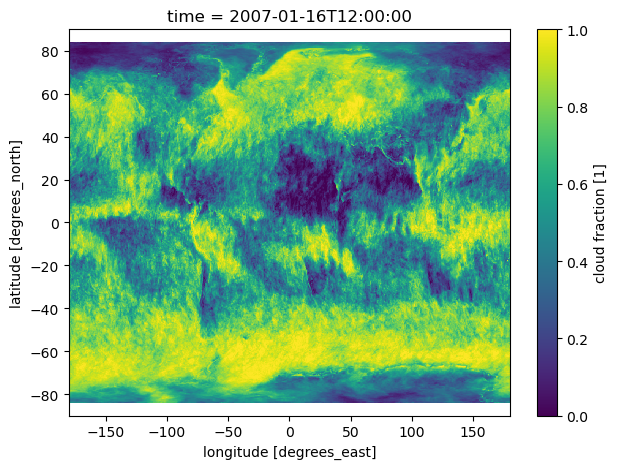

In [9]:
%matplotlib inline

cfc_ds.cfc.isel(time=0).plot()

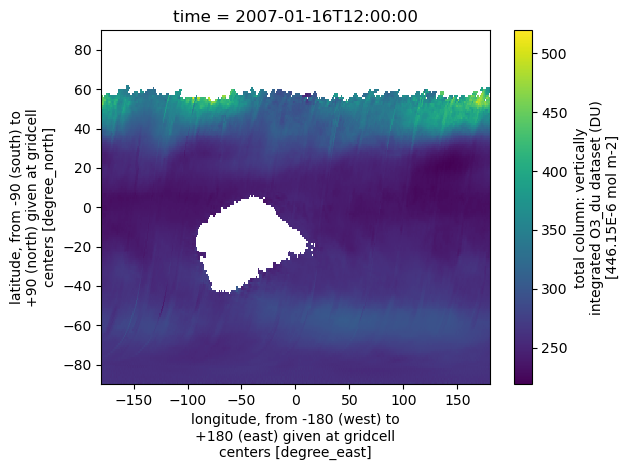

In [10]:
ozone_tot_ds.O3_du_tot.isel(time=0).plot()

Co-register datasets by resampling
----------------------------------

We see that though both datasets are global, they are in different spatial resolutions:

In [11]:
print(cfc_ds['cfc'].shape)
print(ozone_tot_ds['O3_du_tot'].shape)

(6, 360, 720)
(6, 180, 360)


To bring them to the same resolution, we use the ``coregister`` function.

In [12]:
JSON(get_op_meta_info('coregister'))

<IPython.core.display.JSON object>

In [13]:
coregister_op = get_op('coregister')

We get the cloud dataset to the resolution of the ozone dataset.

In [14]:
cfc_res_ds = coregister_op(ozone_tot_ds, cfc_ds)

Check the variable shapes again to see we were successful:

In [15]:
print(cfc_res_ds['cfc'].shape)
print(ozone_tot_ds['O3_du_tot'].shape)

(6, 180, 360)
(6, 180, 360)


And plot again:

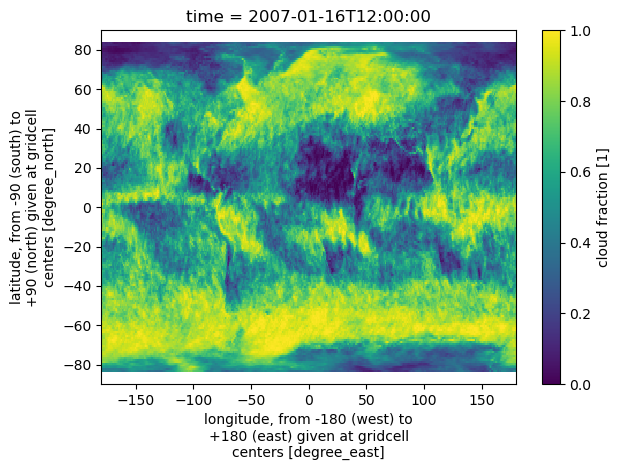

In [16]:
cfc_res_ds.cfc.isel(time=0).plot()

Select the desired spatial region
---------------------------------

We want to continue our analysis with a subset, say, Africa. For this we use ``subset_spatial``.

In [17]:
JSON(get_op_meta_info('subset_spatial'))

<IPython.core.display.JSON object>

In [18]:
subset_spatial_op = get_op('subset_spatial')

In [19]:
africa = '-20.0, -40.0, 60.0, 40.0'
# 'lon_min, lat_min, lon_max, lat_max'
cfc_africa_res_ds = subset_spatial_op(cfc_res_ds, africa)
ozone_tot_africa_ds = subset_spatial_op(ozone_tot_ds, africa)

This is a good time to compare the plots of the resampled subset and the original plot to see the effects of our work:

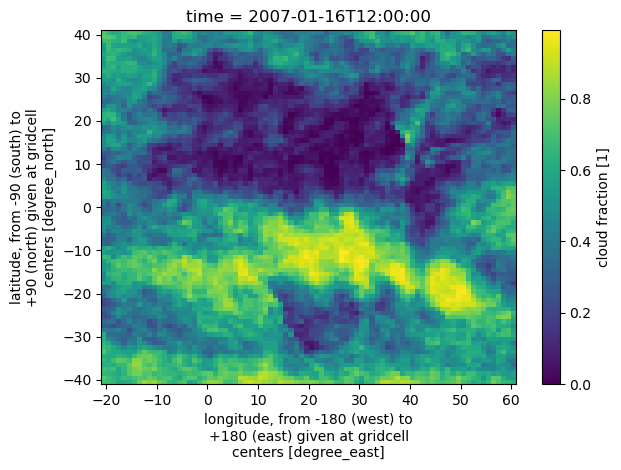

In [20]:
cfc_africa_res_ds.cfc.isel(time=0).plot()

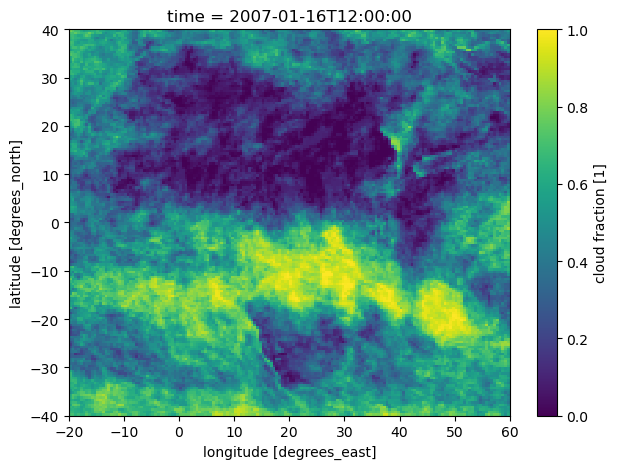

In [21]:
cfc_ds.cfc.isel(time=0).sel({'lat': slice(-40, 40), 'lon': slice(-20, 60)}).plot()

Select the desired temporal region
----------------------------------

We may also create a temporal subset:

In [22]:
JSON(get_op_meta_info('subset_temporal'))

<IPython.core.display.JSON object>

In [23]:
subset_temporal_op = get_op('subset_temporal')

In [24]:
cfc_africa_res_janmar_ds = subset_temporal_op(cfc_africa_res_ds, '2007-01-01, 2007-03-31')
ozone_tot_africa_janmar_ds = subset_temporal_op(ozone_tot_africa_ds, '2007-01-01, 2007-03-31')

In [25]:
print(cfc_africa_res_janmar_ds.time)

<xarray.DataArray 'time' (time: 3)> Size: 24B
array(['2007-01-16T12:00:00.000000000', '2007-02-15T00:00:00.000000000',
       '2007-03-16T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 24B 2007-01-16T12:00:00 ... 2007-03-16T12:...
Attributes:
    standard_name:  time
    bounds:         time_bnds


In [26]:
print(ozone_tot_africa_janmar_ds.time)

<xarray.DataArray 'time' (time: 3)> Size: 24B
array(['2007-01-16T12:00:00.000000000', '2007-02-15T00:00:00.000000000',
       '2007-03-16T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 24B 2007-01-16T12:00:00 ... 2007-03-16T12:...
Attributes:
    standard_name:  time
    bounds:         time_bnds


Retrieve and plot timeseries
----------------------------

Finally, we can create time series from these datasets. Operation ``tseries_point`` can be used to get a time series for a given point, ``tseries_mean`` will get the mean and standard deviation across the dataset.

In [27]:
JSON(get_op_meta_info('tseries_point'))

<IPython.core.display.JSON object>

In [28]:
JSON(get_op_meta_info('tseries_mean'))

<IPython.core.display.JSON object>

In [29]:
tseries_point_op = get_op('tseries_point')
tseries_mean_op = get_op('tseries_mean')

In [30]:
ozone_ts_point = tseries_point_op(ozone_tot_africa_janmar_ds, point='50, 50')
cfc_ts_point = tseries_point_op(cfc_africa_res_janmar_ds, point='50, 50')
ozone_ts_mean = tseries_mean_op(ozone_tot_africa_janmar_ds, var='O3_du_tot')
cfc_ts_mean = tseries_mean_op(cfc_africa_res_janmar_ds, var='cfc')

In [31]:
print(ozone_ts_mean)

<xarray.Dataset> Size: 884B
Dimensions:         (air_pressure: 17, lat: 82, layers: 16, lon: 82, time: 3,
                     bnds: 2)
Coordinates:
  * air_pressure    (air_pressure) float32 68B 1.013e+03 446.0 ... 0.05 0.01
  * lat             (lat) float32 328B -40.5 -39.5 -38.5 ... 38.5 39.5 40.5
  * layers          (layers) int32 64B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * lon             (lon) float32 328B -20.5 -19.5 -18.5 ... 58.5 59.5 60.5
  * time            (time) datetime64[ns] 24B 2007-01-16T12:00:00 ... 2007-03...
    time_bnds       (time, bnds) datetime64[ns] 48B dask.array<chunksize=(3, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    O3_du_tot_mean  (time) float32 12B dask.array<chunksize=(1,), meta=np.ndarray>
    O3_du_tot_std   (time) float32 12B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.7
    title:                      esacci.OZONE.mon.L3.NP.multi-sensor.multi-pla...
    da

In [32]:
print(cfc_ts_mean)

<xarray.Dataset> Size: 728B
Dimensions:   (lat: 82, lon: 82, time: 3)
Coordinates:
  * lat       (lat) float32 328B -40.5 -39.5 -38.5 -37.5 ... 37.5 38.5 39.5 40.5
  * lon       (lon) float32 328B -20.5 -19.5 -18.5 -17.5 ... 57.5 58.5 59.5 60.5
  * time      (time) datetime64[ns] 24B 2007-01-16T12:00:00 ... 2007-03-16T12...
Data variables:
    cfc_mean  (time) float64 24B dask.array<chunksize=(1,), meta=np.ndarray>
    cfc_std   (time) float64 24B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.7
    title:                      esacci.CLOUD.mon.L3C.CLD_PRODUCTS.multi-senso...
    date_created:               2024-11-05T17:48:09.252238
    processing_level:           L3C
    time_coverage_start:        2007-01-16T12:00:00
    time_coverage_end:          2007-03-16T12:00:00
    ...                         ...
    geospatial_lat_min:         -41.0
    geospatial_lat_max:         41.0
    geospatial_lat_units:       degree_north
    geosp

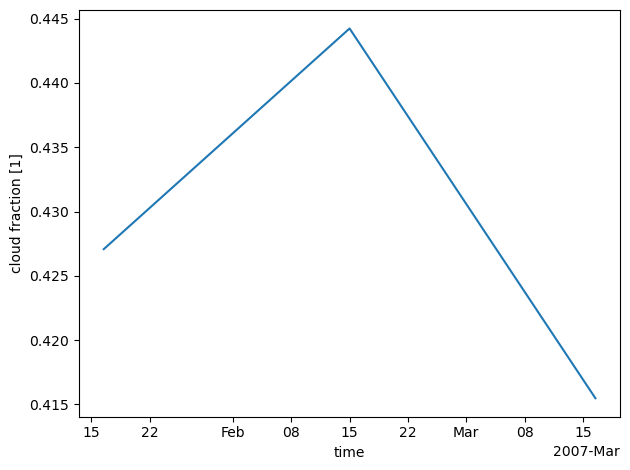

In [33]:
cfc_ts_mean.cfc_mean.plot()

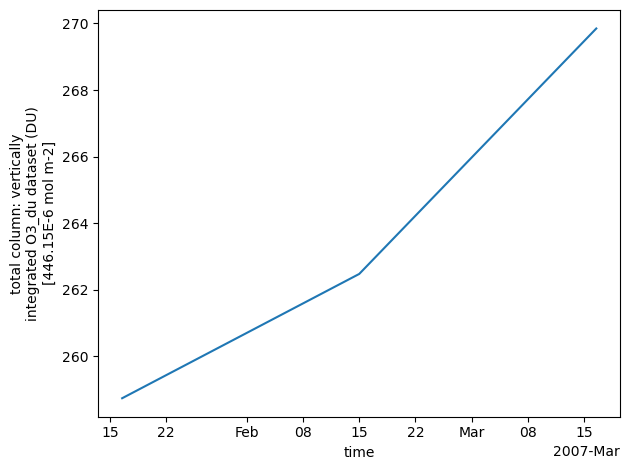

In [34]:
ozone_ts_mean.O3_du_tot_mean.plot()